# Deep Learning in Active Magnetic Regenerators

This Notebook presents the results for the application of Neural Networks in the prediction of the Cooling Capacity ($\dot{Q}_\mathrm{C}$ or $Qc$) and the Magnetization Power ($\dot{W}_\mathrm{m}$ or $Wm$) of Active Magnetic Regenerators. The Dataset consists in 532 points coming from numerical simulations.

### Importing the Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import joblib

tf.config.optimizer.set_jit(True)
mpl.style.use('default')
plt.rc('text',usetex = True)
plt.rc('font', family='serif',size = 12)

C:\Users\Guilherme\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Plotting Functions 

In [2]:
def plot_results(y_train,y_pred_train,y_test,y_pred_test,Obj):
    
    plt.figure()
    plt.plot(y_train,y_pred_train,'.',markersize = 7,color = '#1f77b4', mfc='none', label = 'Training Set')
    plt.plot(y_test,y_pred_test,'x' ,markersize = 5, color = '#2ca02c', mfc='none',label = 'Test Set',)
    
    if Obj == 'Qc':
        Aux = np.linspace(50,300)
        plt.plot(Aux,0.95*Aux,'k--')
        plt.plot(Aux,1.05*Aux,'k--')
        plt.text(140, 180, '$+ 5 \%$', fontsize=12)
        plt.text(150, 120, '$- 5 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{Q}_\mathrm{C}$ [W] - ANN' )
        plt.xlabel(r' $\dot{Q}_\mathrm{C}$ [W] - Numerical Solution')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Qc/Qc - NN.png', format = 'png', bbox_inches='tight') 
    
    elif Obj == 'Wm':
        Aux = np.linspace(10,60)
        plt.plot(Aux,0.95*Aux,'k--')
        plt.plot(Aux,1.05*Aux,'k--')
        plt.text(23, 17, '$- 5 \%$', fontsize=12)
        plt.text(19, 28, '$+ 5 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{W}_\mathrm{AMR,mag}$ [W] - ANN' )
        plt.xlabel(r' $\dot{W}_\mathrm{AMR,mag}$ [W] - Numerical Solution')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Wm/Wm - NN.png', format = 'png', bbox_inches='tight') 

### Reading the Input Parameteres 

The independent variable are the Width ($H$), Height ($H$) and Length ($L$) of the porous medium, the frequency ($f$) and mass flow rate ($mf$) of the Active Magnetic Regenerator, the Inlet Temperatures at the Hot ($Th$) and Cold ($Tc$) ends and the Applied Magnetic Field ($B$).

The dependent variables are the Cooling Capacity ($Qc$) and Magnetization Power ($Wm$).

In [3]:
Inputs = pd.read_excel('Data/Data_AMR.xlsx',index_col = 0, dtype=np.float32) # Input Data
X = Inputs[['W','H','f','mf','B','L','Th','Tc']]
y = Inputs[['Qc','Wm']]

### Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)  

### Scaling the Features

In [5]:
sc = joblib.load('Models/AMR_Scaler.pkl')
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [6]:
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [7]:
#joblib.dump(sc, 'Models/AMR_Scaler.pkl') 

### Building the Model

In [8]:
def Build(hp):
    
    #Grouping a stack of Layers in Model
    model = tf.keras.Sequential()
    model.add(BatchNormalization())
    # Adding the Layers
    # The number of layers, neurons in each one and activation functions are going to be tunned 
    for i in range(hp.Int('layers', 0, 2)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 1, 201, step=2),
                                        activation=hp.Choice('act_' + str(i), ['relu','sigmoid','selu'])))
        #model.add(Dropout(0.2))
        #Applying a Batch Normalization Layer after Dense Layer
        model.add(BatchNormalization())

        
    # Adding a final Layer 
    model.add(tf.keras.layers.Dense(1, activation='selu'))
    
    #model = tfmot.quantization.keras.quantize_model(model)
    # Compiling the Model with the Adam optimization algorithm
    model.compile(optimizer=Adam(),
                            loss="mean_squared_error",
                            #metrics=['accuracy']
                            metrics = ['accuracy']
                            )
    return model

### Batch Optimization

Overriding run_trial in MyTuner (https://kegui.medium.com/how-to-tune-the-number-of-epochs-and-batch-size-in-keras-tuner-c2ab2d40878d)

In [9]:
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 1, 501, step=5)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

### Defining the Tuner

In [10]:
def NeuNet(X_train,y_train,max_epochs,Obj):
    
    # Defining the Tuner
    tuner = MyTuner(Build,
                    objective = 'val_loss',
                    max_epochs = max_epochs,
                    directory='KT_Dir',
                    project_name='KT_Hyperband_' + Obj,
                    executions_per_trial = 1,   
    )
    
    # Hyperparameter Optimization
    tuner.search(X_train,
                 y_train[Obj],
                 epochs=max_epochs,
                 #callbacks=[EarlyStopping('val_loss', patience=5)],
                 verbose=1,
                 validation_split=0.2)
    
  
    # Trainning the Best Model
    best_model = tuner.get_best_models()[0]
    best_model.build(X_train.shape)
    best_model.fit(X_train,
                   y_train[Obj], 
                   epochs=max_epochs,
                   batch_size=tuner.get_best_hyperparameters(num_trials=1)[0].get('batch_size')
    )
    best_model.summary()
    
    # Saving the Model
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN.h5', include_optimizer=False)
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN', include_optimizer=False)
    best_model.save_weights('Models/'+Obj+'/'+ Obj +'_weights.h5')
    #joblib.dump(best_model, 'Models/'+Obj+'/'+ Obj +'_NN.pkl')
    
     #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], best_model.predict(X_train))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], best_model.predict(X_test)))) 

    # Plotting the Results
    plot_results(y_train[Obj], best_model.predict(X_train), y_test[Obj], best_model.predict(X_test), Obj) 

### Defining a Test Function

In [11]:
def Test(X_train,y_train,Obj, Scal):
    
    Model = load_model('Models/'+Obj+'/'+ Obj +'_NN.h5', compile = False)
    Model.summary()
    Model.summary()
    for i, layer in enumerate (Model.layers):
        print (i, layer)
        try:
            print ("    ",layer.activation)
        except AttributeError:
            print('   no activation attribute')
            
    #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], Model.predict(Scal.transform(X_train)))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], Model.predict(Scal.transform(X_test))))) 

    # Plotting the Results
    plot_results(y_train[Obj], Model.predict(Scal.transform(X_train)), y_test[Obj], Model.predict(Scal.transform(X_test)), Obj) 

In [12]:
def Test_lite(X_train,y_train,Obj, Scal):
    
    Model = load_model('Models/'+Obj+'/'+ Obj +'_NN.h5', compile = False)
    Model.summary()
    for i, layer in enumerate (Model.layers):
        print (i, layer)
        try:
            print ("    ",layer.activation)
        except AttributeError:
            print('   no activation attribute')
    converter = tf.lite.TFLiteConverter.from_keras_model(Model)
    tflite_model = converter.convert()
    tflite_models_dir = pathlib.Path("/")
    tflite_models_dir.mkdir(exist_ok=True, parents=True)
    tflite_model_file = tflite_models_dir/"mnist_model.tflite"
    tflite_model_file.write_bytes(tflite_model)
    
    interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
    interpreter.allocate_tensors()
    
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    Train_Lite = []
    for i in range(np.shape(X_train)[0]):
        interpreter.set_tensor(input_index, Scaller.transform(X_train)[i].reshape(-1,1).T)
        interpreter.invoke()
        Train_Lite.append(interpreter.get_tensor(output_index)[0][0])
        
    Test_Lite = []
    for i in range(np.shape(X_test)[0]):
        interpreter.set_tensor(input_index, Scaller.transform(X_test)[i].reshape(-1,1).T)
        interpreter.invoke()
        Test_Lite.append(interpreter.get_tensor(output_index)[0][0])
    
    #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], Train_Lite)))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], Test_Lite)))    
    
    # Plotting the Results
    plot_results(y_train[Obj], Train_Lite, y_test[Obj], Test_Lite, Obj) 

### Training the Models

INFO:tensorflow:Reloading Oracle from existing project KT_Dir\KT_Hyperband_Qc\oracle.json
INFO:tensorflow:Reloading Tuner from KT_Dir\KT_Hyperband_Qc\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/1000
6/6 [==============================] - 1s 2ms/step - loss: 23.5181 - accuracy: 0.0000e+00
Epoch 2/1000
6/6 [==============================] - 0s 2ms/step - loss: 34.6861 - accuracy: 0.0000e+00
Epoch 3/1000
6/6 [==============================] - 0s 2ms/step - loss: 41.0825 - accuracy: 0.0000e+00
Epoch 4/1000
6/6 [==============================] - 0s 2ms/step - loss: 72.3231 - accuracy: 0.0000e+00
Epoch 5/1000
6/6 [==============================] - 0s 2ms/step - loss: 63.3654 - accuracy: 0.0000e+00
Epoch 6/1000
6/6 [==============================] - 0s 2ms/step - loss: 41.6894 - accuracy: 0.0000e+00
Epoch 7/1000
6/6 [==============================] - 0s 2ms/step - loss: 37.9942 - accuracy: 0.0000e+00
Epoch 8/1000
6/6 [==============================] - 0s 2ms/step - loss: 51.8561

6/6 [==============================] - 0s 2ms/step - loss: 39.9837 - accuracy: 0.0000e+00
Epoch 78/1000
6/6 [==============================] - 0s 2ms/step - loss: 31.5232 - accuracy: 0.0000e+00
Epoch 79/1000
6/6 [==============================] - 0s 2ms/step - loss: 31.1771 - accuracy: 0.0000e+00
Epoch 80/1000
6/6 [==============================] - 0s 2ms/step - loss: 28.6539 - accuracy: 0.0000e+00
Epoch 81/1000
6/6 [==============================] - 0s 2ms/step - loss: 33.7108 - accuracy: 0.0000e+00
Epoch 82/1000
6/6 [==============================] - 0s 2ms/step - loss: 25.9542 - accuracy: 0.0000e+00
Epoch 83/1000
6/6 [==============================] - 0s 2ms/step - loss: 48.1349 - accuracy: 0.0000e+00
Epoch 84/1000
6/6 [==============================] - 0s 2ms/step - loss: 37.2132 - accuracy: 0.0000e+00
Epoch 85/1000
6/6 [==============================] - 0s 2ms/step - loss: 80.1469 - accuracy: 0.0000e+00
Epoch 86/1000
6/6 [==============================] - 0s 2ms/step - loss: 58.96

6/6 [==============================] - 0s 2ms/step - loss: 23.3928 - accuracy: 0.0000e+00
Epoch 156/1000
6/6 [==============================] - 0s 2ms/step - loss: 35.6039 - accuracy: 0.0000e+00
Epoch 157/1000
6/6 [==============================] - 0s 2ms/step - loss: 59.2325 - accuracy: 0.0000e+00
Epoch 158/1000
6/6 [==============================] - 0s 2ms/step - loss: 45.6736 - accuracy: 0.0000e+00
Epoch 159/1000
6/6 [==============================] - 0s 2ms/step - loss: 49.5505 - accuracy: 0.0000e+00
Epoch 160/1000
6/6 [==============================] - 0s 2ms/step - loss: 35.9330 - accuracy: 0.0000e+00
Epoch 161/1000
6/6 [==============================] - 0s 2ms/step - loss: 39.9166 - accuracy: 0.0000e+00
Epoch 162/1000
6/6 [==============================] - 0s 2ms/step - loss: 32.0292 - accuracy: 0.0000e+00
Epoch 163/1000
6/6 [==============================] - 0s 2ms/step - loss: 36.5382 - accuracy: 0.0000e+00
Epoch 164/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 35.0673 - accuracy: 0.0000e+00
Epoch 234/1000
6/6 [==============================] - 0s 2ms/step - loss: 44.7699 - accuracy: 0.0000e+00
Epoch 235/1000
6/6 [==============================] - 0s 2ms/step - loss: 55.0688 - accuracy: 0.0000e+00
Epoch 236/1000
6/6 [==============================] - 0s 2ms/step - loss: 27.7534 - accuracy: 0.0000e+00
Epoch 237/1000
6/6 [==============================] - 0s 2ms/step - loss: 29.8388 - accuracy: 0.0000e+00
Epoch 238/1000
6/6 [==============================] - 0s 2ms/step - loss: 32.8520 - accuracy: 0.0000e+00
Epoch 239/1000
6/6 [==============================] - 0s 2ms/step - loss: 27.0461 - accuracy: 0.0000e+00
Epoch 240/1000
6/6 [==============================] - 0s 2ms/step - loss: 37.8017 - accuracy: 0.0000e+00
Epoch 241/1000
6/6 [==============================] - 0s 2ms/step - loss: 48.3404 - accuracy: 0.0000e+00
Epoch 242/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 24.0674 - accuracy: 0.0000e+00
Epoch 312/1000
6/6 [==============================] - 0s 2ms/step - loss: 54.8634 - accuracy: 0.0000e+00
Epoch 313/1000
6/6 [==============================] - 0s 2ms/step - loss: 25.2644 - accuracy: 0.0000e+00
Epoch 314/1000
6/6 [==============================] - 0s 2ms/step - loss: 23.8982 - accuracy: 0.0000e+00
Epoch 315/1000
6/6 [==============================] - 0s 2ms/step - loss: 26.1135 - accuracy: 0.0000e+00
Epoch 316/1000
6/6 [==============================] - 0s 2ms/step - loss: 36.9998 - accuracy: 0.0000e+00
Epoch 317/1000
6/6 [==============================] - 0s 2ms/step - loss: 27.1752 - accuracy: 0.0000e+00
Epoch 318/1000
6/6 [==============================] - 0s 2ms/step - loss: 44.9653 - accuracy: 0.0000e+00
Epoch 319/1000
6/6 [==============================] - 0s 2ms/step - loss: 56.0032 - accuracy: 0.0000e+00
Epoch 320/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 43.7761 - accuracy: 0.0000e+00
Epoch 390/1000
6/6 [==============================] - 0s 2ms/step - loss: 60.0077 - accuracy: 0.0000e+00
Epoch 391/1000
6/6 [==============================] - 0s 2ms/step - loss: 45.0077 - accuracy: 0.0000e+00
Epoch 392/1000
6/6 [==============================] - 0s 2ms/step - loss: 34.5870 - accuracy: 0.0000e+00
Epoch 393/1000
6/6 [==============================] - 0s 2ms/step - loss: 65.1606 - accuracy: 0.0000e+00
Epoch 394/1000
6/6 [==============================] - 0s 2ms/step - loss: 18.4262 - accuracy: 0.0000e+00
Epoch 395/1000
6/6 [==============================] - 0s 2ms/step - loss: 53.7592 - accuracy: 0.0000e+00
Epoch 396/1000
6/6 [==============================] - 0s 2ms/step - loss: 61.5505 - accuracy: 0.0000e+00
Epoch 397/1000
6/6 [==============================] - 0s 2ms/step - loss: 45.6077 - accuracy: 0.0000e+00
Epoch 398/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 52.7789 - accuracy: 0.0000e+00
Epoch 468/1000
6/6 [==============================] - 0s 2ms/step - loss: 46.0999 - accuracy: 0.0000e+00
Epoch 469/1000
6/6 [==============================] - 0s 2ms/step - loss: 28.7852 - accuracy: 0.0000e+00
Epoch 470/1000
6/6 [==============================] - 0s 2ms/step - loss: 25.5819 - accuracy: 0.0000e+00
Epoch 471/1000
6/6 [==============================] - 0s 2ms/step - loss: 41.6437 - accuracy: 0.0000e+00
Epoch 472/1000
6/6 [==============================] - 0s 2ms/step - loss: 33.0326 - accuracy: 0.0000e+00
Epoch 473/1000
6/6 [==============================] - 0s 2ms/step - loss: 48.5363 - accuracy: 0.0000e+00
Epoch 474/1000
6/6 [==============================] - 0s 2ms/step - loss: 30.5799 - accuracy: 0.0000e+00
Epoch 475/1000
6/6 [==============================] - 0s 2ms/step - loss: 24.6184 - accuracy: 0.0000e+00
Epoch 476/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 49.0894 - accuracy: 0.0000e+00
Epoch 546/1000
6/6 [==============================] - 0s 2ms/step - loss: 48.2846 - accuracy: 0.0000e+00
Epoch 547/1000
6/6 [==============================] - 0s 2ms/step - loss: 32.6288 - accuracy: 0.0000e+00
Epoch 548/1000
6/6 [==============================] - 0s 2ms/step - loss: 54.2647 - accuracy: 0.0000e+00
Epoch 549/1000
6/6 [==============================] - 0s 2ms/step - loss: 38.0378 - accuracy: 0.0000e+00
Epoch 550/1000
6/6 [==============================] - 0s 2ms/step - loss: 51.3568 - accuracy: 0.0000e+00
Epoch 551/1000
6/6 [==============================] - 0s 2ms/step - loss: 23.7807 - accuracy: 0.0000e+00
Epoch 552/1000
6/6 [==============================] - 0s 2ms/step - loss: 87.8917 - accuracy: 0.0000e+00
Epoch 553/1000
6/6 [==============================] - 0s 2ms/step - loss: 21.0186 - accuracy: 0.0000e+00
Epoch 554/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 34.1751 - accuracy: 0.0000e+00
Epoch 624/1000
6/6 [==============================] - 0s 2ms/step - loss: 70.2738 - accuracy: 0.0000e+00
Epoch 625/1000
6/6 [==============================] - 0s 2ms/step - loss: 40.2560 - accuracy: 0.0000e+00
Epoch 626/1000
6/6 [==============================] - 0s 2ms/step - loss: 38.9717 - accuracy: 0.0000e+00
Epoch 627/1000
6/6 [==============================] - 0s 2ms/step - loss: 61.3424 - accuracy: 0.0000e+00
Epoch 628/1000
6/6 [==============================] - 0s 2ms/step - loss: 34.4021 - accuracy: 0.0000e+00
Epoch 629/1000
6/6 [==============================] - 0s 2ms/step - loss: 44.6115 - accuracy: 0.0000e+00
Epoch 630/1000
6/6 [==============================] - 0s 2ms/step - loss: 65.1331 - accuracy: 0.0000e+00
Epoch 631/1000
6/6 [==============================] - 0s 2ms/step - loss: 35.2216 - accuracy: 0.0000e+00
Epoch 632/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 39.4636 - accuracy: 0.0000e+00
Epoch 702/1000
6/6 [==============================] - 0s 2ms/step - loss: 15.1877 - accuracy: 0.0000e+00
Epoch 703/1000
6/6 [==============================] - 0s 2ms/step - loss: 41.4696 - accuracy: 0.0000e+00
Epoch 704/1000
6/6 [==============================] - 0s 2ms/step - loss: 51.5857 - accuracy: 0.0000e+00
Epoch 705/1000
6/6 [==============================] - 0s 2ms/step - loss: 48.0728 - accuracy: 0.0000e+00
Epoch 706/1000
6/6 [==============================] - 0s 2ms/step - loss: 38.3252 - accuracy: 0.0000e+00
Epoch 707/1000
6/6 [==============================] - 0s 2ms/step - loss: 46.8217 - accuracy: 0.0000e+00
Epoch 708/1000
6/6 [==============================] - 0s 2ms/step - loss: 53.2923 - accuracy: 0.0000e+00
Epoch 709/1000
6/6 [==============================] - 0s 2ms/step - loss: 38.6028 - accuracy: 0.0000e+00
Epoch 710/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 6ms/step - loss: 32.7796 - accuracy: 0.0000e+00
Epoch 780/1000
6/6 [==============================] - 0s 3ms/step - loss: 40.9760 - accuracy: 0.0000e+00
Epoch 781/1000
6/6 [==============================] - 0s 3ms/step - loss: 34.9299 - accuracy: 0.0000e+00
Epoch 782/1000
6/6 [==============================] - 0s 2ms/step - loss: 29.0065 - accuracy: 0.0000e+00
Epoch 783/1000
6/6 [==============================] - 0s 2ms/step - loss: 40.5691 - accuracy: 0.0000e+00
Epoch 784/1000
6/6 [==============================] - 0s 2ms/step - loss: 37.2985 - accuracy: 0.0000e+00
Epoch 785/1000
6/6 [==============================] - 0s 2ms/step - loss: 47.7011 - accuracy: 0.0000e+00
Epoch 786/1000
6/6 [==============================] - 0s 3ms/step - loss: 78.5689 - accuracy: 0.0000e+00
Epoch 787/1000
6/6 [==============================] - 0s 3ms/step - loss: 37.3370 - accuracy: 0.0000e+00
Epoch 788/1000
6/6 [==============================] - 0s 3ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 35.6601 - accuracy: 0.0000e+00
Epoch 858/1000
6/6 [==============================] - 0s 2ms/step - loss: 26.8706 - accuracy: 0.0000e+00
Epoch 859/1000
6/6 [==============================] - 0s 2ms/step - loss: 47.2125 - accuracy: 0.0000e+00
Epoch 860/1000
6/6 [==============================] - 0s 2ms/step - loss: 34.1555 - accuracy: 0.0000e+00
Epoch 861/1000
6/6 [==============================] - 0s 2ms/step - loss: 60.2098 - accuracy: 0.0000e+00
Epoch 862/1000
6/6 [==============================] - 0s 2ms/step - loss: 59.1873 - accuracy: 0.0000e+00
Epoch 863/1000
6/6 [==============================] - 0s 2ms/step - loss: 45.6344 - accuracy: 0.0000e+00
Epoch 864/1000
6/6 [==============================] - 0s 2ms/step - loss: 29.2394 - accuracy: 0.0000e+00
Epoch 865/1000
6/6 [==============================] - 0s 2ms/step - loss: 53.6215 - accuracy: 0.0000e+00
Epoch 866/1000
6/6 [==============================] - 0s 2ms/step - lo

6/6 [==============================] - 0s 2ms/step - loss: 64.0315 - accuracy: 0.0000e+00
Epoch 936/1000
6/6 [==============================] - 0s 2ms/step - loss: 25.9441 - accuracy: 0.0000e+00
Epoch 937/1000
6/6 [==============================] - 0s 2ms/step - loss: 50.8851 - accuracy: 0.0000e+00
Epoch 938/1000
6/6 [==============================] - 0s 2ms/step - loss: 41.0884 - accuracy: 0.0000e+00
Epoch 939/1000
6/6 [==============================] - 0s 2ms/step - loss: 49.6632 - accuracy: 0.0000e+00
Epoch 940/1000
6/6 [==============================] - 0s 2ms/step - loss: 30.2862 - accuracy: 0.0000e+00
Epoch 941/1000
6/6 [==============================] - 0s 2ms/step - loss: 41.0662 - accuracy: 0.0000e+00
Epoch 942/1000
6/6 [==============================] - 0s 2ms/step - loss: 47.8176 - accuracy: 0.0000e+00
Epoch 943/1000
6/6 [==============================] - 0s 2ms/step - loss: 25.6389 - accuracy: 0.0000e+00
Epoch 944/1000
6/6 [==============================] - 0s 2ms/step - lo

Trainable params: 6,689
Non-trainable params: 316
_________________________________________________________________
INFO:tensorflow:Assets written to: Models/Qc/Qc_NN\assets
14/14 [==============================] - 0s 923us/step
The coefficient of determination for Qc Training Set using Neural Networks is 0.9974713584294653
4/4 [==============================] - 0s 1ms/step
The coefficient of determination for Qc Test Set using Neural Networks is 0.9956141463741772
4/4 [==============================] - 0s 1ms/step


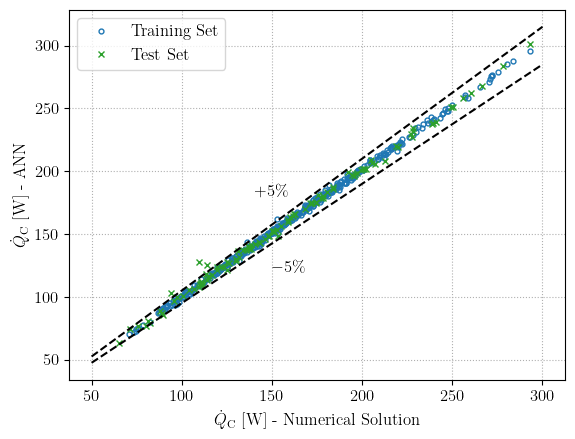

In [13]:
NeuNet(X_train,y_train,1000,'Qc')

INFO:tensorflow:Reloading Oracle from existing project KT_Dir\KT_Hyperband_Wm\oracle.json
INFO:tensorflow:Reloading Tuner from KT_Dir\KT_Hyperband_Wm\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/1000
7/7 [==============================] - 1s 3ms/step - loss: 2.0163 - accuracy: 0.0000e+00
Epoch 2/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.7538 - accuracy: 0.0000e+00
Epoch 3/1000
7/7 [==============================] - 0s 2ms/step - loss: 0.7137 - accuracy: 0.0000e+00
Epoch 4/1000
7/7 [==============================] - 0s 3ms/step - loss: 1.8351 - accuracy: 0.0000e+00
Epoch 5/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.8301 - accuracy: 0.0000e+00
Epoch 6/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.2476 - accuracy: 0.0000e+00
Epoch 7/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.6250 - accuracy: 0.0000e+00
Epoch 8/1000
7/7 [==============================] - 0s 3ms/step - loss: 1.3834 - accur

7/7 [==============================] - 0s 2ms/step - loss: 0.9273 - accuracy: 0.0000e+00
Epoch 79/1000
7/7 [==============================] - 0s 3ms/step - loss: 1.2427 - accuracy: 0.0000e+00
Epoch 80/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.8924 - accuracy: 0.0000e+00
Epoch 81/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.3654 - accuracy: 0.0000e+00
Epoch 82/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.4752 - accuracy: 0.0000e+00
Epoch 83/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.1325 - accuracy: 0.0000e+00
Epoch 84/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.4863 - accuracy: 0.0000e+00
Epoch 85/1000
7/7 [==============================] - 0s 2ms/step - loss: 0.6603 - accuracy: 0.0000e+00
Epoch 86/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.1413 - accuracy: 0.0000e+00
Epoch 87/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.6737 - accur

7/7 [==============================] - 0s 2ms/step - loss: 3.0151 - accuracy: 0.0000e+00
Epoch 158/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.0780 - accuracy: 0.0000e+00
Epoch 159/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.8621 - accuracy: 0.0000e+00
Epoch 160/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.8256 - accuracy: 0.0000e+00
Epoch 161/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.8386 - accuracy: 0.0000e+00
Epoch 162/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.6409 - accuracy: 0.0000e+00
Epoch 163/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.2047 - accuracy: 0.0000e+00
Epoch 164/1000
7/7 [==============================] - 0s 2ms/step - loss: 0.8290 - accuracy: 0.0000e+00
Epoch 165/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.0761 - accuracy: 0.0000e+00
Epoch 166/1000
7/7 [==============================] - 0s 3ms/step - loss: 1.095

7/7 [==============================] - 0s 3ms/step - loss: 3.8323 - accuracy: 0.0000e+00
Epoch 236/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.7261 - accuracy: 0.0000e+00
Epoch 237/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.2396 - accuracy: 0.0000e+00
Epoch 238/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.2074 - accuracy: 0.0000e+00
Epoch 239/1000
7/7 [==============================] - 0s 2ms/step - loss: 3.2735 - accuracy: 0.0000e+00
Epoch 240/1000
7/7 [==============================] - 0s 2ms/step - loss: 0.9392 - accuracy: 0.0000e+00
Epoch 241/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.8847 - accuracy: 0.0000e+00
Epoch 242/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.3843 - accuracy: 0.0000e+00
Epoch 243/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.7259 - accuracy: 0.0000e+00
Epoch 244/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.226

7/7 [==============================] - 0s 2ms/step - loss: 2.9349 - accuracy: 0.0000e+00
Epoch 314/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.6070 - accuracy: 0.0000e+00
Epoch 315/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.6966 - accuracy: 0.0000e+00
Epoch 316/1000
7/7 [==============================] - 0s 1ms/step - loss: 3.4521 - accuracy: 0.0000e+00
Epoch 317/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.5652 - accuracy: 0.0000e+00
Epoch 318/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.3123 - accuracy: 0.0000e+00
Epoch 319/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.9410 - accuracy: 0.0000e+00
Epoch 320/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.0525 - accuracy: 0.0000e+00
Epoch 321/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.0700 - accuracy: 0.0000e+00
Epoch 322/1000
7/7 [==============================] - 0s 3ms/step - loss: 1.359

7/7 [==============================] - 0s 2ms/step - loss: 3.2750 - accuracy: 0.0000e+00
Epoch 392/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.5385 - accuracy: 0.0000e+00
Epoch 393/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.7945 - accuracy: 0.0000e+00
Epoch 394/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.3873 - accuracy: 0.0000e+00
Epoch 395/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.5127 - accuracy: 0.0000e+00
Epoch 396/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.8750 - accuracy: 0.0000e+00
Epoch 397/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.9336 - accuracy: 0.0000e+00
Epoch 398/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.9017 - accuracy: 0.0000e+00
Epoch 399/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.8962 - accuracy: 0.0000e+00
Epoch 400/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.784

7/7 [==============================] - 0s 2ms/step - loss: 0.8866 - accuracy: 0.0000e+00
Epoch 470/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.3488 - accuracy: 0.0000e+00
Epoch 471/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.6813 - accuracy: 0.0000e+00
Epoch 472/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.2521 - accuracy: 0.0000e+00
Epoch 473/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.5091 - accuracy: 0.0000e+00
Epoch 474/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.7031 - accuracy: 0.0000e+00
Epoch 475/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.7330 - accuracy: 0.0000e+00
Epoch 476/1000
7/7 [==============================] - 0s 1ms/step - loss: 3.2311 - accuracy: 0.0000e+00
Epoch 477/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.2821 - accuracy: 0.0000e+00
Epoch 478/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.774

7/7 [==============================] - 0s 2ms/step - loss: 1.0168 - accuracy: 0.0000e+00
Epoch 548/1000
7/7 [==============================] - 0s 1ms/step - loss: 4.9557 - accuracy: 0.0000e+00
Epoch 549/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.9798 - accuracy: 0.0000e+00
Epoch 550/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.0688 - accuracy: 0.0000e+00
Epoch 551/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.3426 - accuracy: 0.0000e+00
Epoch 552/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.7227 - accuracy: 0.0000e+00
Epoch 553/1000
7/7 [==============================] - 0s 1ms/step - loss: 3.1664 - accuracy: 0.0000e+00
Epoch 554/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.3309 - accuracy: 0.0000e+00
Epoch 555/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.5120 - accuracy: 0.0000e+00
Epoch 556/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.027

7/7 [==============================] - 0s 2ms/step - loss: 1.7280 - accuracy: 0.0000e+00
Epoch 626/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.3029 - accuracy: 0.0000e+00
Epoch 627/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.0323 - accuracy: 0.0000e+00
Epoch 628/1000
7/7 [==============================] - 0s 1ms/step - loss: 3.0656 - accuracy: 0.0000e+00
Epoch 629/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.9990 - accuracy: 0.0000e+00
Epoch 630/1000
7/7 [==============================] - 0s 2ms/step - loss: 3.0021 - accuracy: 0.0000e+00
Epoch 631/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.4523 - accuracy: 0.0000e+00
Epoch 632/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.0550 - accuracy: 0.0000e+00
Epoch 633/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.5364 - accuracy: 0.0000e+00
Epoch 634/1000
7/7 [==============================] - 0s 2ms/step - loss: 3.024

7/7 [==============================] - 0s 1ms/step - loss: 2.6167 - accuracy: 0.0000e+00
Epoch 704/1000
7/7 [==============================] - 0s 1ms/step - loss: 3.1653 - accuracy: 0.0000e+00
Epoch 705/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.5293 - accuracy: 0.0000e+00
Epoch 706/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.8227 - accuracy: 0.0000e+00
Epoch 707/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.2154 - accuracy: 0.0000e+00
Epoch 708/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.9923 - accuracy: 0.0000e+00
Epoch 709/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.3160 - accuracy: 0.0000e+00
Epoch 710/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.1446 - accuracy: 0.0000e+00
Epoch 711/1000
7/7 [==============================] - 0s 1ms/step - loss: 3.9282 - accuracy: 0.0000e+00
Epoch 712/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.238

7/7 [==============================] - 0s 1ms/step - loss: 1.0944 - accuracy: 0.0000e+00
Epoch 782/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.9383 - accuracy: 0.0000e+00
Epoch 783/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.7546 - accuracy: 0.0000e+00
Epoch 784/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.7313 - accuracy: 0.0000e+00
Epoch 785/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.9508 - accuracy: 0.0000e+00
Epoch 786/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.2936 - accuracy: 0.0000e+00
Epoch 787/1000
7/7 [==============================] - 0s 2ms/step - loss: 3.9001 - accuracy: 0.0000e+00
Epoch 788/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.0314 - accuracy: 0.0000e+00
Epoch 789/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.1011 - accuracy: 0.0000e+00
Epoch 790/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.539

7/7 [==============================] - 0s 1ms/step - loss: 1.1467 - accuracy: 0.0000e+00
Epoch 860/1000
7/7 [==============================] - 0s 1ms/step - loss: 3.0193 - accuracy: 0.0000e+00
Epoch 861/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.3070 - accuracy: 0.0000e+00
Epoch 862/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.1710 - accuracy: 0.0000e+00
Epoch 863/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.4259 - accuracy: 0.0000e+00
Epoch 864/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.2945 - accuracy: 0.0000e+00
Epoch 865/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.7933 - accuracy: 0.0000e+00
Epoch 866/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.3439 - accuracy: 0.0000e+00
Epoch 867/1000
7/7 [==============================] - 0s 1ms/step - loss: 0.7250 - accuracy: 0.0000e+00
Epoch 868/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.233

7/7 [==============================] - 0s 2ms/step - loss: 1.4180 - accuracy: 0.0000e+00
Epoch 938/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.7142 - accuracy: 0.0000e+00
Epoch 939/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.5135 - accuracy: 0.0000e+00
Epoch 940/1000
7/7 [==============================] - 0s 2ms/step - loss: 0.9841 - accuracy: 0.0000e+00
Epoch 941/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.9699 - accuracy: 0.0000e+00
Epoch 942/1000
7/7 [==============================] - 0s 2ms/step - loss: 1.9265 - accuracy: 0.0000e+00
Epoch 943/1000
7/7 [==============================] - 0s 2ms/step - loss: 2.1400 - accuracy: 0.0000e+00
Epoch 944/1000
7/7 [==============================] - 0s 2ms/step - loss: 0.9289 - accuracy: 0.0000e+00
Epoch 945/1000
7/7 [==============================] - 0s 1ms/step - loss: 2.8757 - accuracy: 0.0000e+00
Epoch 946/1000
7/7 [==============================] - 0s 1ms/step - loss: 1.685

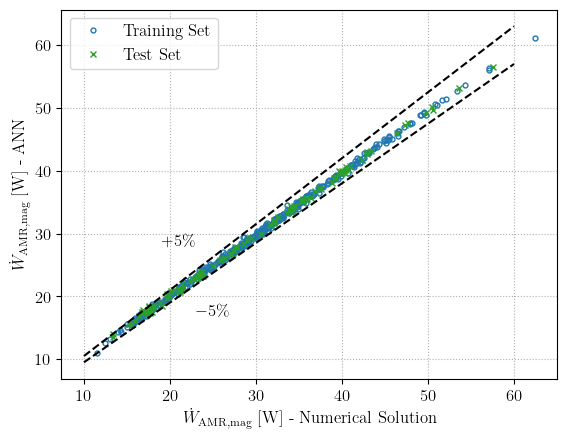

In [14]:
NeuNet(X_train,y_train,1000,'Wm')

### Testing the Models

### Reading the Input Parameteres 

In [15]:
Inputs = pd.read_excel('Data/Data_AMR.xlsx',index_col = 0, dtype=np.float32) # Input Data
X = Inputs[['W','H','f','mf','B','L','Th','Tc']]
y = Inputs[['Qc','Wm']]

### Train-Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)  

### Scaling the Features

In [17]:
Scaller = joblib.load('Models/AMR_Scaler.pkl')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 69)                621       
                                                                 
 batch_normalization_1 (Batc  (None, 69)               276       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 81)                5670      
                                                                 
 batch_normalization_2 (Batc  (None, 81)               324       
 hNormalization)                                                 
                                                        

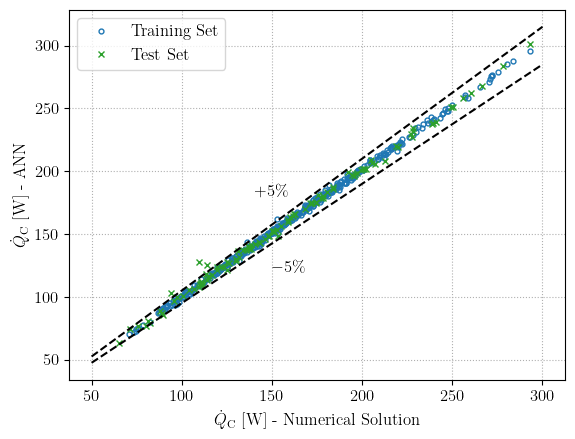

In [18]:
Test(X_train,y_train,'Qc',Scaller)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 149)               1341      
                                                                 
 batch_normalization_1 (Batc  (None, 149)              596       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 150       
                                                                 
Total params: 2,119
Trainable params: 1,805
Non-trainable params: 314
_________________________________________________________________
Model: "sequential"
________________________________

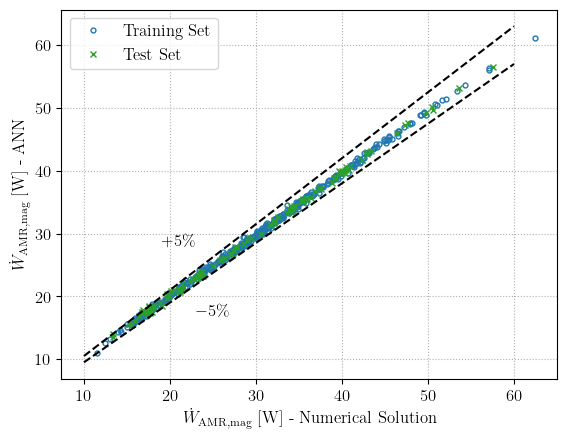

In [19]:
Test(X_train,y_train,'Wm',Scaller)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 69)                621       
                                                                 
 batch_normalization_1 (Batc  (None, 69)               276       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 81)                5670      
                                                                 
 batch_normalization_2 (Batc  (None, 81)               324       
 hNormalization)                                                 
                                                        

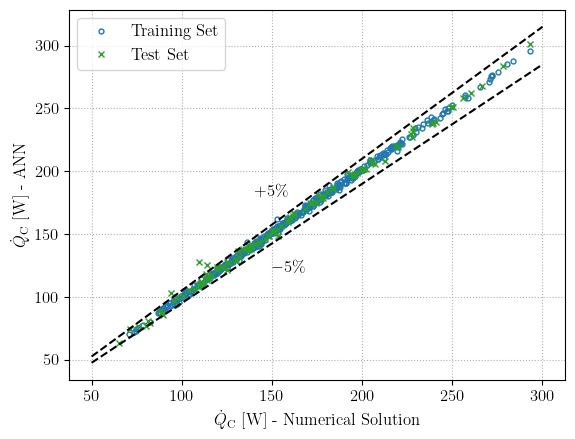

In [20]:
Test_lite(X_train,y_train,'Qc',Scaller)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 149)               1341      
                                                                 
 batch_normalization_1 (Batc  (None, 149)              596       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 150       
                                                                 
Total params: 2,119
Trainable params: 1,805
Non-trainable params: 314
_________________________________________________________________
0 <keras.layers.normalization.batch_normalization.Ba

INFO:tensorflow:Assets written to: C:\Users\Guilherme\AppData\Local\Temp\tmp4728_nqa\assets


The coefficient of determination for Wm Training Set using Neural Networks is 0.9982381984156617
The coefficient of determination for Wm Test Set using Neural Networks is 0.9984724764633889


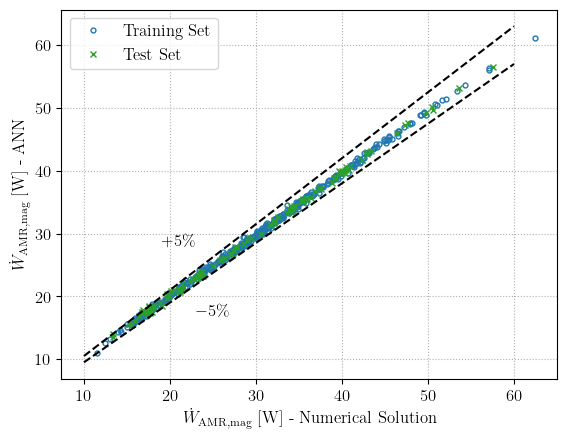

In [21]:
Test_lite(X_train,y_train,'Wm',Scaller)